In [3]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from global_land_mask import globe
import scipy.stats as stats
import os
import importlib
import geopandas as gpd
# from tqdm import tqdm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.cm as cm

# file containing functions:
import loadquakes
from loadquakes import calculate_bayes
from tqdm import tqdm
importlib.reload(loadquakes)
plt.style.use('fivethirtyeight')

In [6]:
# GRACE data
dataset_path = '/data/fast1/surface-load/'
ds = xr.open_dataset(dataset_path + "GRCTellus.JPL.200204_202201.GLO.RL06M.MSCNv02CRI.nc")
catalog = pd.read_csv('catalog.csv')
etas_declustered = pd.read_csv('etas_declustered.csv')
NND_declustered = pd.read_csv('NND_declustered.csv') # eta0 = 10
NND_declustered_v2 = pd.read_csv('NND_declustered_v2.csv') # eta0 = 10**3

In [10]:
sliq_etas=etas_declustered.sort_values('cp',ascending=False)
sliq_etas=sliq_etas.reset_index()
sliq_etas=sliq_etas.drop(['index'], axis=1)
sliq_etas['dmass']=sliq_etas['dmass'].astype(float)


thr = 1.5
sliq_etas_sig = sliq_etas[sliq_etas.cp>1.5]

Mean on land: -0.5360996671043267, skew: 0.4315387025092388
Mean not on land: -6.016807922831493, skew: 1.2861323088958831


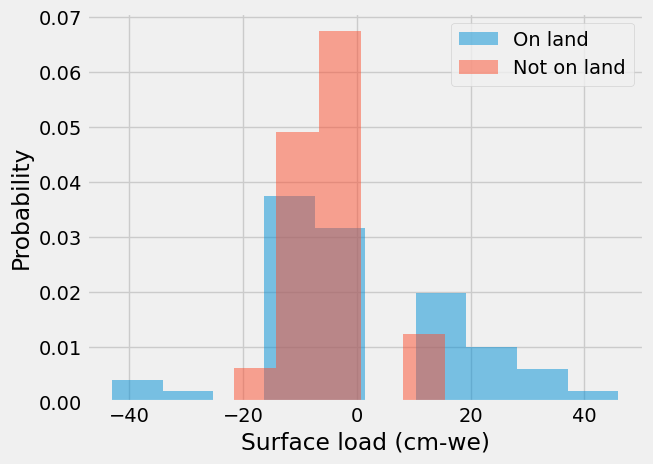

In [12]:
# Check if a point is on land:
from scipy.stats import skew
is_on_land = globe.is_land(sliq_etas_sig.latitude, sliq_etas_sig.longitude) 
is_not_on_land = ~globe.is_land(sliq_etas_sig.latitude, sliq_etas_sig.longitude)

dmass = sliq_etas_sig.dmass

plt.hist(dmass[is_on_land],10,density=True,alpha=0.5,label='On land')
plt.hist(dmass[is_not_on_land],5,density=True,alpha=0.5,label='Not on land')
plt.xlabel('Surface load (cm-we)')
plt.ylabel('Probability')
print(f'Mean on land: {np.mean(dmass[is_on_land])}, skew: {skew(dmass[is_on_land])}')
print(f'Mean not on land: {np.mean(dmass[is_not_on_land])}, skew: {skew(dmass[is_not_on_land])}')
# print(f'Mean globa: {np.mean(sliq_etas.dmass)}, skew: {skew(sliq_etas.dmass)}')
plt.legend()
plt.show()

# put this in supplemental figure with caption that includes skew, mean, and that the Z-test states that they aren't significantly different.

In [13]:
'''
2-sample Z-test
'''

mu1 = np.mean(dmass[is_on_land])
mu2 = np.mean(dmass[is_not_on_land])
std1 = np.std(dmass[is_on_land])
std2 = np.std(dmass[is_not_on_land])
n1 = len(dmass[is_on_land])
n2 = len(dmass[is_not_on_land])

print(f'Z = {(mu1-mu2)/np.sqrt((std1**2/n1) + (std2**2/n2))}')

Z = 2.0009514636953574


In [ ]:
def land_mask(full_catalog,events,color,label,vmin,vmax,markersize_scale,circle_scale=1e-5):
    
    is_on_land = globe.is_land(events.latitude, events.longitude)
    
    ocean_lat = []
    ocean_lon = []

    for i in range(len(events)):
        if is_on_land[i]==False:
            lat = events.latitude[i]
            lon = events.longitude[i]
            ocean_lat.append(lat)
            ocean_lon.append(lon)

    gdf=gpd.GeoDataFrame(events, geometry=gpd.points_from_xy(ocean_lon,
                                                             ocean_lat))
    
    world=gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    ax=world.plot(color='white', edgecolor='black', figsize=(15,10))
    divider=make_axes_locatable(ax)
    cax=divider.append_axes("bottom", size="5%", pad=0.6)
    
    # plotting all events in tiny grey dots
    ax.scatter(full_catalog.longitude,full_catalog.latitude,c="darkgrey",marker=".")
    
    for i in [5,6,7,8]:
        ax.scatter(0,
                   1000,
                   c="silver",
                   s=circle_scale*i**(markersize_scale),
                   label=f'        M {i}.0',
                   edgecolor='k')
        
    cmap = cm.get_cmap('seismic',15) # 15 discrete colors
    gdf.plot(ax=ax,cax=cax,alpha=0.5,column=color,cmap=cmap,legend=True,
             edgecolor='k',
             markersize=circle_scale*(events.magnitude)**markersize_scale,
             legend_kwds={'label': "Surface mass load during event (cm-we)",
                            'orientation': "horizontal"},
            vmax=vmax,
            vmin=vmin)
    
    gdf.plot(ax=ax,facecolor="None",
         edgecolor='k',
         markersize=circle_scale*(events.magnitude)**markersize_scale)
    
    ax.set_xlabel('Longitude', fontsize=15)
    ax.set_ylabel("Latitude", fontsize=15)
    ax.set_title(label)
    
    ax.legend(
       fontsize=12,
       bbox_to_anchor=(1.01, 0.99, 0.1, 0.1),
       labelspacing=6,
       frameon=False,
       borderpad=3)

# legend for nyingchi map
#     ax.legend(
#         fontsize=12,
#         labelspacing=6,
#         frameon=True,
#         borderpad=2,
#         framealpha=1)
    
    ax.set_ylim([-90,90])
    return ax